In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
#from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
import os
import time
# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

## Charger des données MNIST à partir de Torchvision
Torchvision permet de charger les données du MNIST de manière pratique. Nous utiliserons un batch_size de 64 pour la formation et de 1000 pour les tests sur cet ensemble de données. Les valeurs 0,1307 et 0,3081 utilisées pour la transformation Normalize() ci-dessous sont la moyenne globale et l'écart-type de l'ensemble de données MNIST. **transforme.ToTensor()** convertit l'ensemble du tableau en tenseur de torche et le divise par 255.  Les valeurs sont donc comprises entre 0,0 et 1,0.

In [4]:
# On defini la transformation qui normalise les données
transform = transforms.Compose([ transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                               ])

In [5]:
# On télécharge et charge les données 
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw


Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw


Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw
Processing...


/Users/vw12/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [26]:
len(test_set),len(train_set)


(10000, 60000)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

## Preproccessing des données

In [23]:
epochs = 10
batch_size_train = 64
batch_size_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Pour des expériences répétable il est important de fixer la graine
Il faut souligner que **cudnn** n'utilise que les algorithmes non déterministes qui peuvent est désactivés **$torch.backends.cudnn.enabled = False$**

Dans PyTorch, **DataLoader** contient quelques options interessantes autres que dataset et batch size. par exemple l'utilisation de $num workers >1$ pour utiliser les sous processus pour charger les données de manière asynchrone ou utiliser la RAM (via **pin_memory**) pour accelérer les transfert de RAM vers le GPU

In [16]:
examples = enumerate(testLoader)
batch_idx, (images, labels) = next(examples)
print("le type de données: ",type(images)) # Checking the datatype 
print("la tailles des images :", images.shape) # the size of the image
print("la taille des labels :", labels.shape) # the size of the labels

le type de données:  <class 'torch.Tensor'>
la tailles des images : torch.Size([64, 1, 28, 28])
la taille des labels : torch.Size([64])


Transformons notre objet trainloader en un itérateur avec iter afin que nous puissions accéder à nos images et à nos étiquettes à partir de ce générateur. Nous pouvons voir la forme comme $64\times 1\times 28\times 28$. cela signifi que:

- 64: Represents 64 images
- 1 : un cannal donc la couleur ==>> Grayscale(grise)
- $28$ par 28 pixel: la forme des images


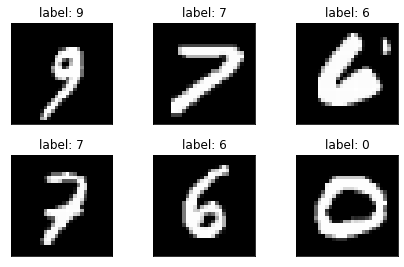

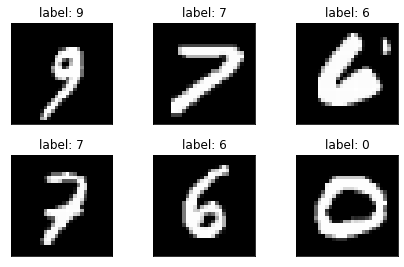

In [20]:

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='gray')
    plt.title("label: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])
fig

## construction du réseau

 

Nous allons constuire notre réseau en utilisant la méthode **nn.module** dans la classe des objets orientées. Ce réseau sera composé de 2 couches de convolutions 2D suivies de des couches FC. Comme fonctions d'activations on utilisera la ReLU et comme moyen de regularisation  on utilisera le Dropout

La fonction **Forward()** définie la façon dont on calcule la sortie en utilisant les couches

In [21]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # couche du réseau de convolution
        self.convolutaional_neural_network_layers = nn.Sequential(
                # ici on defini notre couche de covolution 2D
                # On peut calculer la taille de sortie de chaque de convolution comme:
                # outpout = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # On a in_channels=1 parce que nos images sont en noire et blanc
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1),#(N, 1, 28, 28) 
                nn.ReLU(),
                # après la première couche de convolution la sortie est
                # [(28 + 2*1 - 3)/1] + 1 = 28. 
                nn.MaxPool2d(kernel_size=2), 
                # Puisqu'on appliqué le max pooling avec kernel=2, on a divisé par 2, donc on obtient
                # 28 / 2 = 14
          
                # la sortie de la seconde couche
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # la taille de sortie est :
                # [(14 + 2*1 - 3)/1] + 1 = 14. 
                nn.MaxPool2d(kernel_size=2) 
                # Puisqu'on appliqué le max pooling avec kernel=2, on a divisé par 2, donc on obtient
                # 14 / 2 = 7
        )

        # les couches linéaires
        self.linear_layers = nn.Sequential(
                # On a output_channel=24 de la seconde couche, et 7*7 est derivée par la formule
                # qui est la sortie de chaque couche
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), 
                nn.Linear(in_features=64, out_features=10) # on a 10 classes
        )
        
    # Définition de la passe avant 

    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # Après avoir obtenu la sortie de notre couche convolutionnelle,
        # nous devons l'aplatir ou réorganiser la sortie en un vecteur        
        x = x.view(x.size(0), -1)
        # puis ça passe à travers les couches linéaires
        x = self.linear_layers(x)
        return x

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

La fonction forward() pass (la passe en avant) définit la façon dont notre sortie est calculée. La ligne x.view(x.size(0), -1) aplatit la sortie de la couche de convolution en un vecteur. La plupart du temps, lors de l'expérimentation de modèles plus complexes, il est conseillé d'afficher les valeurs du tenseur pour faciliter le débogage.

Définissons les optimiseurs que nous utiliserons.

In [22]:
model = Network()
model.to(device)


Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

Après la passe en avant, la loss function est calculée à partir de la **sortie souhaitée( etiquette)** et les prédictions  afin de mettre à jour les poids. La mise en place de la fonction de perte est une étape assez simple. On utilise ici la perte d'entropie croisée, qui mesure la performance d'un modèle de classification dont la sortie est une valeur de probabilité comprise entre 0 et 1. Il convient de noter que la perte d'entropie croisée augmente lorsque la probabilité prévue diverge de l'étiquette réelle.

Ensuite, nous utiliserons l'optimiseur Stochastic Gradient Descent pour la mise à jour des hyperparamètres model.parameters() fournira les paramètres pouvant être appris à l'optimiseur et lr=0.01 définit les pas d'apprentissage pour les mises à jour des paramètres.



In [55]:
network = Net()

optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)


Il est important de noter que lorsqu'on utilise le GPU pour entrainer le réseau, il faudra envoyer les paramètres du modèles au GPU en utilisant **model.cuda**. C'est important de transférer les paramètres aux device appropriés avant de les passer à l'optimiseur, sinon l'optimiseur ne sera pas capable de les suivrent 




## Apprentissage et test du modèle

Le chargement des données est géré par Dataloader, ensuite on commence à mettre à zero le gradient en utilisant **optimizer.zero_grad()** puisque Pytorch par defaut cummule le gradient
le **backward()** permet de collecter le nouveau  gradient qu'on propagera dans les paramètres du réseau via à **optimizer.step()**

Notre modèle est maintenant prêt à être entrainé. On commençe par établir une taille d'époque. Une époque c'est, lorsqu'on traverse toute la base de données une seule fois pendant l'apprentissage. 

In [42]:
epochs = 3
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

def Training(epochs):
    for epoch in range(epochs):

        total_train_loss = 0
        total_val_loss = 0

        model.train()

        total = 0
        # training our model
        for idx, (image, label) in enumerate(trainLoader):
            # cela est nécessaire lorsqu'on travaille sur un GPU
            #image, label = image.to(device), label.to(device)
            # mettre le gradient à zero
            optimizer.zero_grad()
            output= model(image)

            loss = F.nll_loss(output, label)
            total_train_loss += loss.item()
            # retropropager la loss dans le réseau
            loss.backward()
            optimizer.step()

            pred = F.softmax(output, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy_train = total / len(train_set)
        accuracy_total_train.append(accuracy_train)

        total_train_loss = total_train_loss / (idx + 1)
        train_loss.append(total_train_loss)

        # test de notre modèle
        model.eval()
        total = 0
        for idx, (image, label) in enumerate(testLoader):
            pred = model(image)
            loss = F.nll_loss(pred, label)
            total_val_loss += loss.item()

            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy_val = total / len(test_set)
        accuracy_total_val.append(accuracy_val)

        total_val_loss = total_val_loss / (idx + 1)
        val_loss.append(total_val_loss)

        if epoch % 2 == 0:
            print("Epoch: {}/{}  ".format(epoch, epochs),
                "Training loss: {:.4f}  ".format(total_train_loss),
                "Testing loss: {:.4f}  ".format(total_val_loss),
                "Train accuracy: {:.4f}  ".format(accuracy_train),
                "Test accuracy: {:.4f}  ".format(accuracy_val))

In [43]:
Training(epochs)

Epoch: 0/3   Training loss: nan   Testing loss: nan   Train accuracy: 0.0987   Test accuracy: 0.0980  
Epoch: 2/3   Training loss: nan   Testing loss: nan   Train accuracy: 0.0987   Test accuracy: 0.0980  
